# Predicting SAP stock prices
## Using PyTorch and SageMaker

---


## Instructions

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.


## Step 1: Downloading the data

We use the historical data from a polish provide Stooq.
Visit https://stooq.com/q/d/?s=sap.de to fine-tune the data.

In [1]:
import numpy as np
import pandas as pd

# Global settings
use_sinus_data = False  # Replaces stoc price with syntetic sinus curve - to debug training and prediction
forecast_days = 1       # How many days to the future shall the value be predicted

In [2]:
%mkdir -p "data"
# Clean existing data if necessary
!rm -rf "data/*"

!curl -k -sS "https://stooq.com/q/d/l/?s=sap.de&i=d" > "data/data.raw.csv"
# i=d - interval daily (other: w,m,q,y - week, month, quarter, year)
# o=1100000 - options - binary mask 
# other...

We may want to start learning with simpler data, so here is the option to replace stock prices with `sin` signal

In [3]:
def create_target_for_supervised(src, target, shift=1):
    """
    This function shifts target forward by `shift` positions with respect to the src
    Example for shift=1:
    [a,b,c] [a,b,c] -> [a,b,c] [x,a,b]
    """
    src = pd.DataFrame(src)
    target = pd.DataFrame(target)
    
    src = src.iloc[:(shift * -1)]
    target = target.iloc[shift:]
    
    # Data was shifted and 'empty spaces' in form of NaNs emerged
    # We may fill it with zeros:
    # src.fillna(0, inplace=True)
    # or interpolate
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
    src.interpolate(method='nearest', inplace=True)
    target.interpolate(method='nearest', inplace=True)
    
    src.reset_index(inplace=True, drop=True)
    target.reset_index(inplace=True, drop=True)

    return src, target

def replace_stock_data_with_sine(input_data, target_data):
    np.random.seed(2)

    N = len(input_data)
    L = len(input_data)
    
    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)).reshape(N, 1)
    data = np.sin(x / 3.1415 / 2.0).astype('float64')
    input_data['AvgPrice'] = data
    target_data['AvgPrice'] = data # target_data should be shifted with respect to input_data. We do it later
    input_data['Volume'] =  np.ones(N, 'float64')
    
    return input_data, target_data

## Step 2: Preparing and Processing the data

Default data range used at stooq is: September 1994 until today

In [4]:
import os
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

def read_stock_data(data_dir='data/'):  
    ymd_date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    return pd.read_csv(data_dir+"data.raw.csv", parse_dates=['Date'], date_parser=ymd_date_parser)
   
    
def select_columns(raw):
    input_data = pd.DataFrame({
        "AvgPrice": raw['Low'] + (raw['High'] - raw['Low'])/2
    })
    target_data = input_data.copy()
    return input_data, target_data


def plot_data(input_data, target_data, title= "no title", first_days=None):
    plt.figure(figsize=(16,5))
    x_axis = range(0,len(target_data))
    plt.title(title)
    plt.plot(x_axis[:first_days], input_data[:first_days], 'b.-', label='input')
    plt.plot(x_axis[:first_days], target_data[:first_days], 'r.-', label='target')

    plt.legend(loc='best')
    plt.show()

In [5]:
raw_data = read_stock_data()
print("Raw data imported from the source:\n ", raw_data.head(5))


Raw data imported from the source:
          Date    Open    High     Low   Close    Volume
0 1994-09-13  2.9978  3.0020  2.9978  3.0020  161888.0
1 1994-09-14  2.9910  3.0377  2.9821  3.0377  420909.0
2 1994-09-16  3.0576  3.0576  3.0576  3.0576   97134.0
3 1994-09-20  3.0576  3.0576  3.0576  3.0576   48566.0
4 1994-09-21  3.0576  3.0576  3.0576  3.0576  161888.0


In [6]:
input_data, target_data = select_columns(raw_data)

if use_sinus_data:
    input_data, target_data = replace_stock_data_with_sine(input_data, target_data)

input_data, target_data = create_target_for_supervised(input_data, target_data, forecast_days)

print("Shape of input:\n", input_data.shape)
print("Shape of target:\n", target_data.shape)

print("Head of input:\n", input_data.head(5))
print("Head of target:\n", target_data.head(5))

Shape of input:
 (6048, 1)
Shape of target:
 (6048, 1)
Head of input:
    AvgPrice
0    2.9999
1    3.0099
2    3.0576
3    3.0576
4    3.0576
Head of target:
    AvgPrice
0    3.0099
1    3.0576
2    3.0576
3    3.0576
4    3.0933


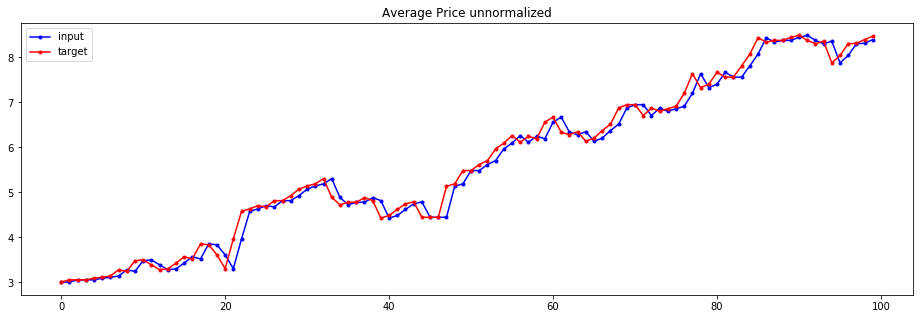

In [7]:
plot_data(input_data['AvgPrice'], target_data['AvgPrice'], "Average Price unnormalized", first_days=100)

In [8]:
# Check if data is clean
# Check for NaN, None, and other non-numerical data
print("There are {} null values in input".format(input_data.isnull().values.sum()))
print("There are {} null values in target".format(target_data.isnull().values.sum()))

columns = input_data.columns.values.tolist()
for column in columns:
    index = input_data[column].index[input_data[column].apply(np.isnan)]
    print('Index {} in column {} is NaN or Null'.format(index,column))

There are 0 null values in input
There are 0 null values in target
Index Int64Index([], dtype='int64') in column AvgPrice is NaN or Null


In [9]:
def divide_stock_data(data, labels):
    """Prepare training and test sets from stock data."""
    
    data_len = len(data)
    # division point between train and test data
    ratio = 0.95
    division_index = int(data_len*ratio)
    
    data_train = data[:division_index]
    data_test = data[division_index:]
    labels_train = labels[:division_index]
    labels_test = labels[division_index:]
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [10]:
train_X_orig, test_X_orig, train_y_orig, test_y_orig = divide_stock_data(input_data, target_data)
print("Stock days in data set: train = {}, test = {}".format(len(train_X_orig), len(test_X_orig)))

Stock days in data set: train = 5745, test = 303


## Scaling Data

Data should be normalized to simplify the learning process.
In this case, we use `StandardScaler` to standardize features by removing the mean and scaling to unit variance.

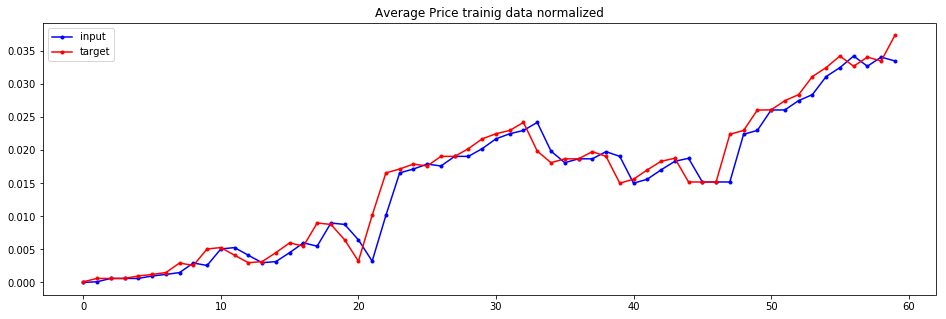

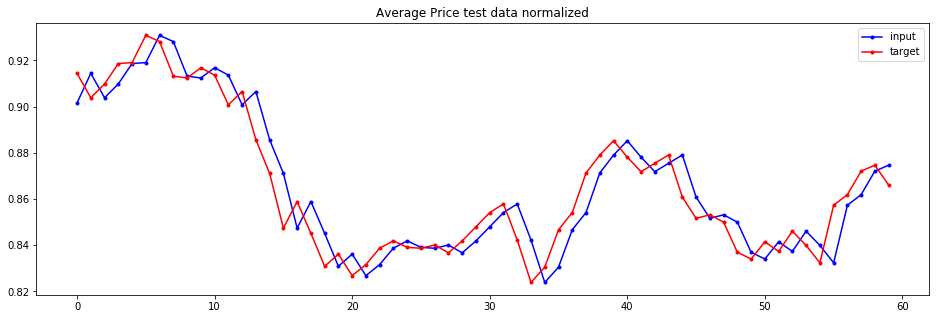

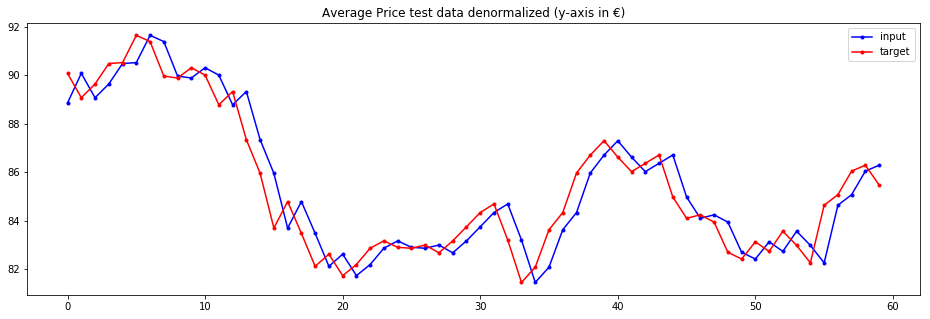

In [11]:
# Normalization of data
from pandas import Series
from sklearn.preprocessing import StandardScaler,MinMaxScaler

train_X = train_X_orig.copy()
train_y = train_y_orig.copy()
test_X  = test_X_orig.copy() 
test_y  = test_y_orig.copy() 

# We fit scalers using training data and then apply scaling to both training and test datasets
# We treat test data as we would never have seen it before

# scaler_price = StandardScaler()
scaler_price = MinMaxScaler()
scaler_price.fit(train_X[['AvgPrice']].values)

train_X[['AvgPrice']] = scaler_price.transform(train_X[['AvgPrice']])
train_y[['AvgPrice']] = scaler_price.transform(train_y[['AvgPrice']])

test_X[['AvgPrice']] = scaler_price.transform(test_X[['AvgPrice']])
test_y[['AvgPrice']] = scaler_price.transform(test_y[['AvgPrice']])

plot_data(train_X['AvgPrice'], train_y['AvgPrice'], "Average Price trainig data normalized", 60)
plot_data(test_X['AvgPrice'], test_y['AvgPrice'], "Average Price test data normalized", 60)

# How to go back to the unscaled price/volume
denorm_X=scaler_price.inverse_transform(test_X[['AvgPrice']])
denorm_y=scaler_price.inverse_transform(test_y[['AvgPrice']])

plot_data(denorm_X, denorm_y, "Average Price test data denormalized (y-axis in €)", 60)

Now that we have our training and testing sets unified and prepared, we should do a quick check and see an example of the data our model will be trained on. This is generally a good idea as it allows you to see how each of the further processing steps affects the reviews and it also ensures that the data has been loaded correctly.

In [12]:
print("Ideal prediction done at day 0:")
print(train_y[0:1])
print("Shoudl equal the average price from day 1:")
print(train_X[1:2])

print("\nThe same should hold for test data.")
print("Ideal prediction done at day 0:")
print(test_y[0:1])
print("Shoudl equal the average price from day 1:")
print(test_X[1:2])

Ideal prediction done at day 0:
   AvgPrice
0  0.000105
Shoudl equal the average price from day 1:
   AvgPrice
1  0.000105

The same should hold for test data.
Ideal prediction done at day 0:
      AvgPrice
5745  0.914413
Shoudl equal the average price from day 1:
      AvgPrice
5746  0.914413


## Step X: Upload the data to S3

Training and test data are packed into a csv file an uploaded to S3 from where Sagemaker jobs can pull the data.

In [13]:
data_dir = 'data'

pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join('data', 'train.csv'), header=False, index=False)


pd.concat([pd.DataFrame(test_y), pd.DataFrame(test_X)], axis=1) \
        .to_csv(os.path.join('data', 'test.csv'), header=False, index=False)

## Step 4: Build and Train the PyTorch Model

In the XGBoost notebook we discussed what a model is in the SageMaker framework. In particular, a model comprises three objects

 - Model Artifacts,
 - Training Code, and
 - Inference Code,
 
each of which interact with one another. In the XGBoost example we used training and inference code that was provided by Amazon. Here we will still be using containers provided by Amazon with the added benefit of being able to include our own custom code.

We will start by implementing our own neural network in PyTorch along with a training script. For the purposes of this project we have provided the necessary model object in the `model.py` file, inside of the `train` folder. You can see the provided implementation by running the cell below.

In [14]:
!pygmentize train/model.py

import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.25)
        self.linear = nn.Linear(in_features=self.hidden_dim, out_features=output_dim)

    def init_hidden(self):
        # Initializes hidden layer with zeros
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))

    def forward(self, input_X):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
 

The important takeaway from the implementation provided is that there are three parameters that we may wish to tweak to improve the performance of our model. These are the embedding dimension, the hidden dimension and the size of the vocabulary. We will likely want to make these parameters configurable in the training script so that if we wish to modify them we do not need to modify the script itself. We will see how to do this later on. To start we will write some of the training code in the notebook so that we can more easily diagnose any issues that arise.

First we will load a small portion of the training data set to use as a sample. It would be very time consuming to try and train the model completely in the notebook as we do not have access to a gpu and the compute instance that we are using is not particularly powerful. However, we can work on a small bit of the data to get a feel for how our training script is behaving.

In [15]:
import torch
import torch.utils.data

batch_size = 50

# Read all data from file to calculate data length
dummy_read = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None)
num_rows_train = (len(dummy_read) // batch_size) * batch_size

# Read again so many rows, so that num_rows/batch_size is an integer
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=num_rows_train)

# Order of data in train.csv:
# Y-Average  |  X-Average  
# to_predict |  INPUT VALUE

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).float()

#print(train_sample)
print(train_sample_y.shape)
print(train_sample_X.shape)

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=batch_size)

torch.Size([5700])
torch.Size([5700, 1])


### Writing the training method and testing it locally

Next we need to write the training code itself. This should be very similar to training methods that you have written before to train PyTorch models. We will leave any difficult aspects such as model saving / loading and parameter loading until a little later.

In [16]:
# Contents of train/train.py

import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.25)
        self.linear = nn.Linear(in_features=self.hidden_dim, out_features=output_dim)

    def init_hidden(self):
        # Initializes hidden layer with zeros
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))

    def forward(self, input_X):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        # Input should be reshaped from [batch_size] to [1, batch_size, input_dim]
        lstm_input = input_X.view(1, self.batch_size, self.input_dim)
        lstm_out, _ = self.lstm(lstm_input.float())
        out = self.linear(lstm_out)
        result1 = out

        return result1

In [17]:
import torch
from torch import nn
import torch.optim as optim

from train.model import LSTM
   
def train(model, train_loader, epochs, optimizer, criterion, device):
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        
        
        for batch in train_loader:
            batch_X, batch_y = batch
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            model.zero_grad()
            
            output = model(batch_X)
           
            loss = criterion(output.squeeze(), batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, MSELoss: {}".format(epoch, total_loss / len(train_loader)))
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))
model = LSTM(input_dim=1, hidden_dim=64, batch_size=batch_size, output_dim=1, num_layers=2).to(device)

print(model)


optimizer = optim.Adam(model.parameters(), lr=0.002)
loss_fn = torch.nn.MSELoss()

train(model, train_sample_dl, 10, optimizer, loss_fn, device)

Using device: cpu
LSTM(
  (lstm): LSTM(1, 64, num_layers=2, dropout=0.25)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 1, MSELoss: 0.009421254514228693
Epoch: 2, MSELoss: 0.036466975169452395
Epoch: 3, MSELoss: 0.02770509033596905
Epoch: 4, MSELoss: 0.012355770692393938
Epoch: 5, MSELoss: 0.002425938031018105
Epoch: 6, MSELoss: 0.0007128186418987369
Epoch: 7, MSELoss: 0.0006658936351110848
Epoch: 8, MSELoss: 0.0005763992951854067
Epoch: 9, MSELoss: 0.0005571405982712014
Epoch: 10, MSELoss: 0.0005409268493135562


LSTM(
  (lstm): LSTM(1, 64, num_layers=2, dropout=0.25)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

In [18]:
import torch
import torch.utils.data

test_dummy = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None, names=None)

num_rows_test = (len(test_dummy) // batch_size) * batch_size

test_sample = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None, names=None, nrows=num_rows_test)
test_y = torch.from_numpy(test_sample[[0]].values).float().squeeze()

test_X = torch.from_numpy(test_sample.drop([0], axis=1).values).float()

print(test_y.shape)
print(test_X.shape)

# Build the dataset
test_ds = torch.utils.data.TensorDataset(test_X, test_y)
# Build the dataloader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

from sklearn.metrics import *


def test(model, test_loader, criterion, device):
    model.eval()
    data = dict()
    data['prediction'] = []
    data['expected'] = []
    total_loss = 0
    total_rmse = 0

    for batch in test_loader:
        batch_X, batch_y = batch
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
    
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        
        # Calculate errors - note copying data from GPU to CPU!
        flat_output = output.cpu().detach().numpy().reshape(-1,1)              
        flat_y = batch_y.cpu().detach().numpy()
        data['prediction'].append(flat_output)
        data['expected'].append(flat_y)
        total_rmse += mean_squared_error(flat_output, rmse_x)
        total_loss += loss.data.item()
        
    print("test:mseloss: {}".format(total_loss / len(test_loader)))
    print("test:rmse: {}".format(total_rmse))
    return data

loss_fn = torch.nn.MSELoss()
result = test(model, test_dl, loss_fn, device)

torch.Size([300])
torch.Size([300, 1])
batch_X:
 tensor([[0.9016],
        [0.9144],
        [0.9038],
        [0.9098],
        [0.9187],
        [0.9191],
        [0.9309],
        [0.9282],
        [0.9132],
        [0.9124],
        [0.9168],
        [0.9136],
        [0.9008],
        [0.9065],
        [0.8857],
        [0.8711],
        [0.8474],
        [0.8589],
        [0.8451],
        [0.8308],
        [0.8361],
        [0.8268],
        [0.8316],
        [0.8387],
        [0.8419],
        [0.8391],
        [0.8387],
        [0.8401],
        [0.8367],
        [0.8419],
        [0.8480],
        [0.8541],
        [0.8579],
        [0.8422],
        [0.8239],
        [0.8305],
        [0.8467],
        [0.8541],
        [0.8713],
        [0.8790],
        [0.8852],
        [0.8781],
        [0.8718],
        [0.8754],
        [0.8791],
        [0.8609],
        [0.8516],
        [0.8531],
        [0.8500],
        [0.8369]])
output:
 tensor([[[0.9099],
         [0.9206],
   

### Displaying prediction results

Note that Y-axis is still normalized and some values are $> 1$.
This means that they are `out of scale`, and the predictor will have problems with precise preodiction in such cases, because it have never seen such training data before.

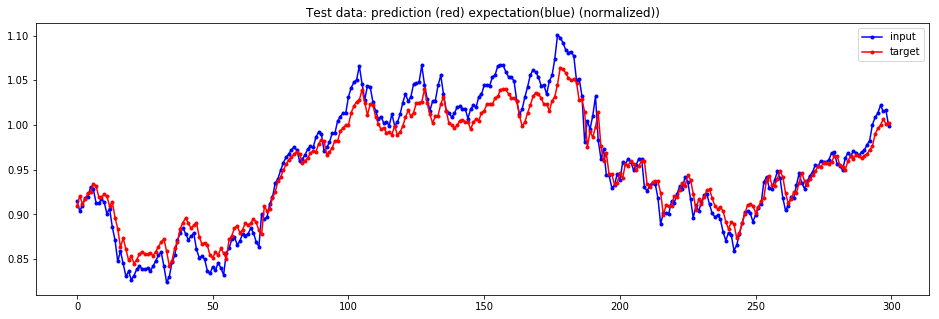

In [19]:
# Remove batching from result
predictions = []
for batch_arr in result['prediction']:
    for value in batch_arr:
        predictions.append(value)

expectations = []
for batch_arr in result['expected']:
    for value in batch_arr:
        expectations.append(value)
        


plot_data(np.array(expectations).reshape(-1, 1), 
          np.array(predictions).reshape(-1, 1), 
          "Test data: prediction (red) expectation(blue) (normalized))", len(expectations))

### Invert scaling transformation

Let's look at the chart with Y-axis expressed in euro

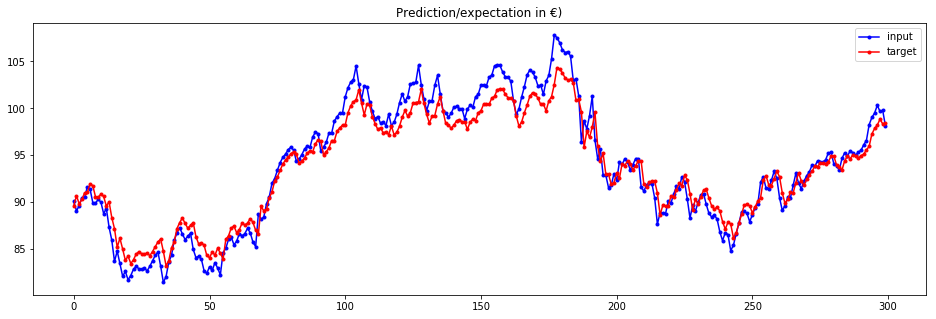

In [20]:
exp = scaler_price.inverse_transform(np.array(expectations).reshape(-1, 1))
pred = scaler_price.inverse_transform(np.array(predictions).reshape(-1, 1))

plot_data(exp, pred, "Prediction/expectation in €)", len(expectations))

# STOP HERE



### Uploading the training data to S3


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [21]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock-predictor-dojo1'

role = sagemaker.get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-628201230330


In [22]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

In [23]:
instance_type_training = 'ml.p2.xlarge'
instance_type_deployment = 'ml.m4.xlarge'
# Must be a 'ml.*'instance, for example:
# - ml.m4.xlarge - new EC2 instance with CPU
# - ml.p2.xlarge - new EC2 instance with GPU

In [24]:
from sagemaker.pytorch import PyTorch

# TODO: Make these work in CloudWatch
metric_definitions = [{'Name': 'Training-Loss',
                       'Regex': 'train:mseloss: ([0-9\\.]+)'}]

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type=instance_type_training,
                    metric_definitions = metric_definitions,
                    hyperparameters={
                        'epochs': 100,
                        'hidden-dim': 640,
                        'batch-size': 50,
                        'num-layers': 4,
                        'learning-rate': 0.0001 # Keep not higher than 0.0002
                    })

In [25]:
# Training with given hyperparameters
estimator.fit({'training': input_data})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-628201230330
INFO:sagemaker:Creating training-job with name: sagemaker-pytorch-2019-03-29-14-07-52-639


2019-03-29 14:07:53 Starting - Starting the training job...
2019-03-29 14:07:54 Starting - Launching requested ML instances......
2019-03-29 14:09:03 Starting - Preparing the instances for training.........
2019-03-29 14:10:45 Downloading - Downloading input data
2019-03-29 14:10:45 Training - Downloading the training image.....
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-03-29 14:11:28,229 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-03-29 14:11:28,255 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-03-29 14:11:29,665 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-03-29 14:11:29,975 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2019-03-29 14:11:29,976 sagemaker-containers INFO     Generating setup.cfg
2019-03-29 14:11:29,976 sagemaker-containe

Model loaded with hidden_dim 640, batch_size 50, num_layers 4.
Getting train data loader.
Epoch: 1
train:mseloss: 0.020697978115206576
Epoch: 2
train:mseloss: 0.05370524630288536
Epoch: 3
train:mseloss: 0.045371777236588265
Epoch: 4
train:mseloss: 0.0401297820486402
Epoch: 5
train:mseloss: 0.035413570296026466
Epoch: 6
train:mseloss: 0.029535711295210876
Epoch: 7
train:mseloss: 0.02211513106764566
Epoch: 8
train:mseloss: 0.014196360242510165
Epoch: 9
train:mseloss: 0.007386804102951142
Epoch: 10
train:mseloss: 0.0036003583674691824
Epoch: 11
train:mseloss: 0.0019179269995156414
Epoch: 12
train:mseloss: 0.0012596944184782874
Epoch: 13
train:mseloss: 0.0010107267970804394
Epoch: 14
train:mseloss: 0.0008783106535255476
Epoch: 15
train:mseloss: 0.0007849300549296139
Epoch: 16
train:mseloss: 0.0006888977009670302
Epoch: 17
train:mseloss: 0.0006101419509688736
Epoch: 18
train:mseloss: 0.0006018964714920067
Epoch: 19
train:mseloss: 0.0005804601008557048
Epoch: 20
train:mseloss: 0.000527495069

Note the `Billable seconds: XX` output -  this is the total cost of running the training instance. 
This allows to run powerful multi-GPU instances at the same time minimizing the AWS costs.

By navigating to trining jobs (https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs) one can see vaious details like: monitorig of resources usage, potential errors, etc.

The trained model is stored in S3, so that it can be deployed and used in a predictior predictor later.

Deployed predictior is a EC2 instance holding the trained model. 
It can be accessed via `endpoint`. All endpoints are listed under: https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints

In [26]:
# existing_endpoint_name = predictor.endpoint
# print(existing_endpoint_name)
# shall_update = True if existing_endpoint_name else False
# print(shall_update)

In [27]:
# Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, 
                         instance_type=instance_type_deployment)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2019-03-29-14-07-52-639
INFO:sagemaker:Creating endpoint with name sagemaker-pytorch-2019-03-29-14-07-52-639


-------------------------------------------------------------------------!

[[1.0085975]]


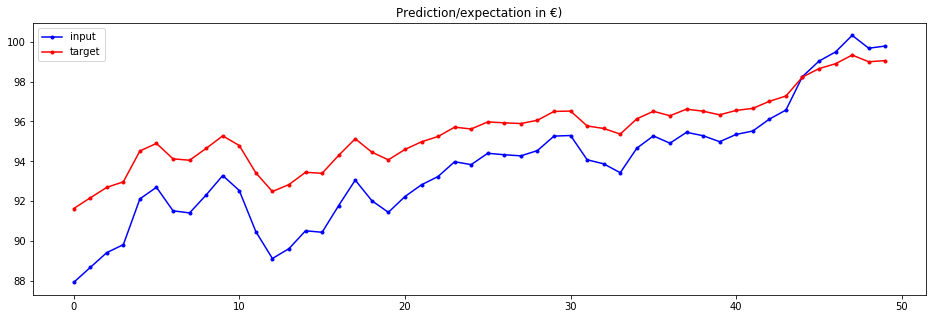

In [28]:
# Let's get princes of SAP stocks from the last batch_size days
input_1 = np.array(test_X[-1*batch_size:])

# Predict the prices
result = predictor.predict(input_1)
result = np.array(result).reshape(-1, 1)

# The price tomorrow will be:
print(result[-1:])

input_scaled = scaler_price.inverse_transform(input_1.reshape(-1, 1))
result_scaled = scaler_price.inverse_transform(result)

plot_data(input_scaled, result_scaled, "Prediction/expectation in €)", len(input_1))


In [29]:
def predict(data, rows=batch_size):
    predictions = np.array([])
    
    batched = data.view(-1, batch_size)
    for batch in batched:
        result = predictor.predict(batch)
        npr = np.array(result)
        predictions = np.append(predictions, npr)
    
    return predictions

In [30]:
# Test using all batches from the testing data set
predictions = predict(test_X, batch_size)
predictions = [num for num in np.array(predictions)]

In [31]:
from sklearn.metrics import *

print("mean_absolute_error: ", mean_absolute_error(test_y, np.array(predictions)))
print("mean_squared_error: ", mean_squared_error(test_y, np.array(predictions)))
print("mean_squared_log_error: ", mean_squared_log_error(test_y, np.array(predictions)))
print("median_absolute_error: ", median_absolute_error(test_y, np.array(predictions)))
print("r2_score: ", r2_score(test_y, np.array(predictions)))

mean_absolute_error:  0.026904087464014688
mean_squared_error:  0.0009922538626644694
mean_squared_log_error:  0.00026798658437511726
median_absolute_error:  0.025743812322616577
r2_score:  0.7973738477862142


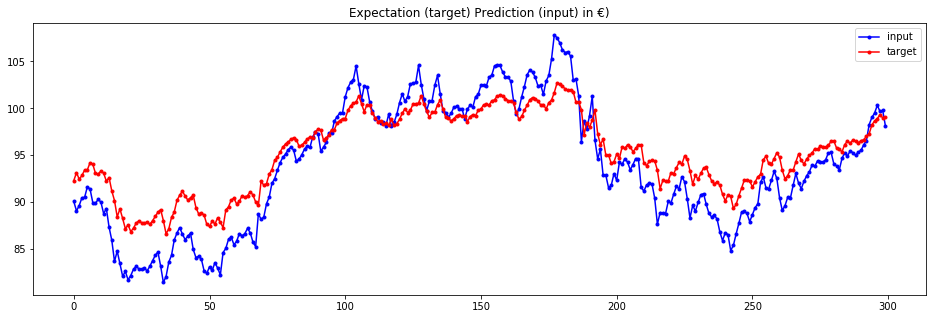

In [34]:
target_scaled = scaler_price.inverse_transform(test_y.numpy().reshape(-1, 1))
result_scaled = scaler_price.inverse_transform(np.array(predictions).reshape(-1, 1))

plot_data(target_scaled, result_scaled, "Expectation (target) Prediction (input) in €)", len(test_y))


In [35]:
# Check how the predictor performs on the original training set (expect: overfitting)


predictions_train = predict(train_X, batch_size)
predictions_train = [num for num in np.array(predictions_train)]

print("mean_absolute_error: ", mean_absolute_error(test_y, np.array(predictions_train)))
print("mean_squared_error: ", mean_squared_error(test_y, np.array(predictions_train)))
print("mean_squared_log_error: ", mean_squared_log_error(test_y, np.array(predictions_train)))
print("median_absolute_error: ", median_absolute_error(test_y, np.array(predictions_train)))
print("r2_score: ", r2_score(test_y, np.array(predictions_train)))

target_scaled_train = scaler_price.inverse_transform(train_y.numpy().reshape(-1, 1))
result_scaled_train = scaler_price.inverse_transform(np.array(predictions_train).reshape(-1, 1))

plot_data(target_scaled_train, result_scaled_train, "Expectation (target) Prediction (input) in €)", len(test_y))

AttributeError: 'DataFrame' object has no attribute 'view'

In [36]:
# If you forget to delete the endpoint, the EC2 instace will keep running and generating costs
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-pytorch-2019-03-29-14-07-52-639
INFO:sagemaker:Deleting endpoint with name: sagemaker-pytorch-2019-03-29-14-07-52-639
